# Comparison of different bias mitigation methods on accuracy and bias metrics

The goal of this analysis is to make a comparison of different bias mitigation methods for classification problems on different types of dataset and to see how these methods impact on different fairness metrics and on the accuracy of the classifier. The datasets on which we will test the fairness algorithms are:

1. Unbias dataset
2. Bias unbalanced dataset
3. Bias balanced dataset

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from numpy.random import default_rng
from collections import OrderedDict
sns.set_theme()

from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover, LFR

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels
%matplotlib inline

In [2]:
# utility functions
def compute_dataset_fairness_metrics(data: BinaryLabelDataset, unpriv_group: list, priv_group: list):
    """ Computes: Disparate Impact and Statistical Parity """
    
    b = BinaryLabelDatasetMetric(data, unprivileged_groups=unpriv_group, privileged_groups=priv_group)
    metrics = dict()
    metrics['Disparate Impact'] = b.disparate_impact()
    metrics['Statistical Parity'] = b.statistical_parity_difference()
    for k in metrics:
        print("%s = %.4f" % (k, metrics[k]))
    return metrics

def compute_fairness_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Computes: Balanced Accuracy 
    Statistical Parity Difference
    Disparate Impact
    Average odds difference
    Equal Opportunity Difference
    Theil Index """
    
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

def build_dataset(n_samples, n_features, n_informative, n_sensitive):
    """"Builds a syntetic dataset for classification"""
    x, y = make_classification(n_samples=n_samples, 
                               n_features=n_features, 
                               n_informative=n_informative)
    data = pd.DataFrame(np.column_stack((x,y)), columns=[i for i in range(11)])
    s = np.arange(n_sensitive)
    s = np.repeat(s,n_samples/2)
    rnd = default_rng()
    rnd.shuffle(s)
    data['s'] = s
    return data

def split_data(data: BinaryLabelDataset):
    #data = BinaryLabelDataset(df=data, label_names=label_names, protected_attribute_names=protect_attr_names)
    data_train, data_tv = data.split([0.7], shuffle=True)
    data_test, data_valid = data_tv.split([0.5], shuffle=True)
    return data_train, data_test, data_valid

def x_y_split_dir(train, test):
    x_train = np.delete(train.features, train.feature_names.index('s'), axis=1)
    y_train = train.labels.ravel()
    x_test = np.delete(test.features, test.feature_names.index('s'), axis=1)
    y_test = test.labels.ravel()
    return x_train, y_train, x_test, y_test

def x_y_split(data_train: BinaryLabelDataset, data_test: BinaryLabelDataset):
    X_train = data_train.features
    Y_train = data_train.labels.ravel()
    X_test = data_test.features
    Y_test = data_test.labels.ravel()
    return X_train, Y_train, X_test, Y_test

def compute_classification_metrics(estimator, valid_data):
    
    """"Computes the bias classification metrics 
    in addition to the classification report and a confusion matrix"""
    
    pred = valid_data.copy()
    pred.labels = estimator.predict(pred.features)
    plot_classification_report(classification_report(valid_data.labels, pred.labels))
    plot_confusion_matrix(valid_data.labels, pred.labels, {'1', '0'}, normalize=True)
    class_metrics = compute_fairness_metrics(valid_data, pred, unprivileged_group, privileged_group)
    return class_metrics

def merge_datasets(datasets: dict):
    keys = list(datasets.keys())
    first_data = datasets.pop(keys[0])
    merged_metrics = pd.DataFrame(first_data, index=[0])
    merged_metrics.loc[0,'Dataset'] = keys[0]
    index = 1
    for k,v in datasets.items():
        merged_metrics = merged_metrics.append(v, ignore_index=True)
        merged_metrics.loc[index,'Dataset'] = k
        index = index + 1
    merged_data = merged_metrics.melt(id_vars='Dataset', value_name='values', var_name='metrics')
    return merged_data

In [3]:
# plot functions

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]), 
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:-4]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.tight_layout()

def plot_metrics_comparison(bias_class_metrics, rw_class_metrics, title1='', title2=''):
    fig,ax = plt.subplots(1,2,figsize=(15,5))
    keys = list(bias_class_metrics.keys())
    vals = [float(bias_class_metrics[k]) for k in keys]
    sns.barplot(x=keys, y=vals,ax=ax[0])
    for k in keys:
        ax[0].text(keys.index(k), 
                   bias_class_metrics[k], 
                   round(bias_class_metrics[k], 3), 
                   ha="center",
                   va="bottom",
                   fontsize="medium"
                  )
    keys = list(rw_class_metrics.keys())
    vals = [float(rw_class_metrics[k]) for k in keys]
    sns.barplot(x=keys, y=vals,ax=ax[1])
    for k in keys:
        ax[1].text(keys.index(k), 
                   rw_class_metrics[k], 
                   round(rw_class_metrics[k], 3), 
                   ha="center",
                   va="bottom",
                   fontsize="medium"
                  )
    ax[0].tick_params(labelrotation=90)
    ax[0].set(title=title1)
    ax[1].tick_params(labelrotation=90)
    ax[1].set(title=title2)
    return ax

def plot_syntesis(dataset, title):
    fig, ax = plt.subplots(1,1,figsize=(15,5))
    unbias_fig = sns.barplot(data = dataset, x='metrics', y='values', hue='Dataset', ax=ax)
    plt.ylabel(ylabel='')
    plt.xlabel(xlabel='')
    plt.title(title)
    return ax

## Dataset fairness metrics definition

The group fairness metrics related to the dataset are defined as follows:

- **Disparate impact**

$$
\frac{Pr(Y=1|S=unprivileged)}{Pr(Y=1|S=privileged)}
$$

> If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data

- **Statistical parity**

$$
Pr(Y=1|S=unprivileged)-Pr(Y=1|S=privileged)
$$

## Classifier fairness metrics definition

The group fairness metrics related to the classifier are defined below:

- **Balanced Accuracy**

$$
\frac{TP + TN}{2}
$$

- **Statistical parity**

$$
Pr(\hat{Y}=1|S=unprivileged)-Pr(\hat{Y}=1|S=privileged)
$$

- **Disparate Impact**

$$
\frac{Pr(\hat{Y}=1|S=unprivileged)}{Pr(\hat{Y}=1|S=privileged)}
$$

>If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data
- **Average odds difference**

$$
\frac{[(FPR_{S=unpriv} - FPR_{S=priv})+(TPR_{S=unpriv} - TPR_{S=priv})]}{2}
$$
>A value of 0 means _equality of odds_

- **Equal opportunity difference**

$$
TPR_{S=unpriv} - TPR_{S=priv}
$$

- **Theil Index**

$$
\frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln(\frac{b_{i}}{\mu}) \\
\text{with: } b_i=\hat{y_i}-y_i+1 \text{ and $\mu$ is the mean of $b_i$ }
$$
>Individual index measuring the distance of each individual predicted y from his real value. A value of 0 means equality. 

## Bias mitigation algorithms

In the following we will test two preprocessing bias mitigation algorithms and we will compare the impact they have on the model accuracy. The algorithms that we will test are the following:

1. **Reweighing**
    
> Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification

2. **Disparate Impact Remover**

> This algorithm changes the values of the target variable at different levels of repair. An higher level of repair removes the disparate impact but loweres the accuracy, while a low level of repair does not change the data. The values of the target variable $y$ are changed s.t. the mean of the $y$ distribution is the mean between the mean of $y$ distribution for the privileged and unprivileged groups. 
>
> Following the pre processing procedure suggested by M. Feldman et al. in _"Certifying and removing disparate impact." ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 2015_, we first scale the values s.t. the minimum is 0 and the maximum is 1 and then remove the sensitive variable from the dataset before training the classifier. 

<!--3. **LFR**

> Learning fair representations is a pre-processing technique that finds a latent representation which encodes the data well but obfuscates information about protected attributes-->

## Dataset creation

Here we will create a binary labeled dataset with 10.000 samples and 11 features of which 4 are informative features and one will act as sensitive attribute:

In [4]:
n_samples = 10000
n_features = 10
n_informative = 4
n_sensitive = 2

In [5]:
data = build_dataset(n_samples, n_features, n_informative, n_sensitive)
data.head()

,0,1,2,3,4,5,6,7,8,9,10,s
0,0.238799,-0.388973,-0.356140,0.719368,1.168927,-1.257698,1.418067,0.939002,1.913549,-2.226470,0.0,1
1,2.123617,0.057706,-2.232313,1.065188,4.857043,1.674499,3.548544,-0.067750,3.293859,-1.775241,0.0,0
2,0.466157,-0.134811,-0.204265,-0.036917,1.355964,-0.061429,0.977476,-0.250091,0.353166,-0.026485,0.0,1
3,-1.209376,-1.488665,-0.068955,0.952567,-0.189333,-0.779067,-0.738419,-0.530160,2.480678,0.479845,0.0,1
4,-0.632499,-0.978054,-0.524732,-0.897829,1.415963,-0.397176,0.752517,-0.094086,2.378918,1.307925,0.0,1


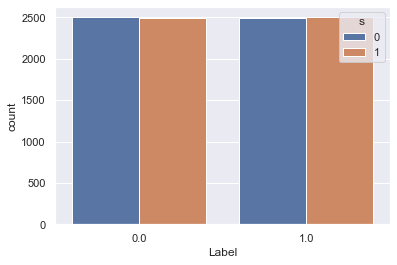

In [6]:
ax = sns.barplot(
    x=10, y='count', 
    hue='s', 
    data=data.groupby('s')[10].value_counts().rename('count').reset_index(),
)
ax.set(xlabel= 'Label')
plt.show()

The dataset seems to be fair with respect to the sensitive attribute

In [7]:
unprivileged_group = [{'s': 0}]
privileged_group = [{'s': 1}]

# Unbias dataset

Here we will apply the metrics and the algorithms defined above on the unbias version of the dataset and compare how these bias mitigation algorithms change the different metrics.

## Dataset fairness metrics 

Let's compute the dataset fairness metrics defined above on the syntetic dataset to check that it is really unbias

In [8]:
bin_data = BinaryLabelDataset(df=data, label_names=[10], protected_attribute_names=['s'])
fair_data_train, fair_data_test, fair_data_valid = split_data(bin_data)
metrics = compute_dataset_fairness_metrics(fair_data_train, unprivileged_group, privileged_group)

Disparate Impact = 0.9903
Statistical Parity = -0.0049


The dataset is not bias.

## Classification bias metrics

Here we train and test a _Logistic Regression_ classifier:

In [9]:
X_train, Y_train, X_test, Y_test = x_y_split(fair_data_train, fair_data_test)
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe_fit = pipe.fit(X_train, Y_train, logisticregression__sample_weight=fair_data_train.instance_weights.ravel())
score = cross_val_score(pipe_fit, X_test, Y_test)
print("Accuracy: %f"% np.mean(score))

Accuracy: 0.860667


Balanced accuracy = 0.8555
Statistical parity difference = -0.0372
Disparate impact = 0.9287
Average odds difference = -0.0322
Equal opportunity difference = -0.0360
Theil index = 0.0956


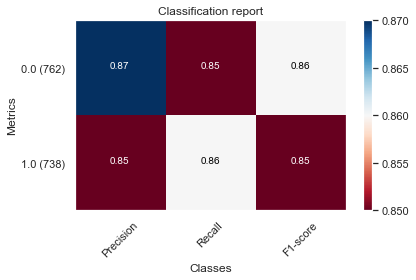

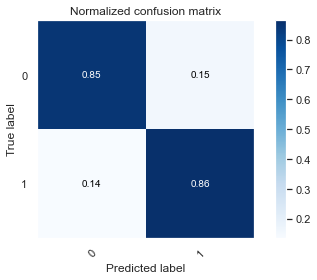

In [10]:
class_metrics = compute_classification_metrics(pipe_fit, fair_data_valid)
plt.show()

From the values of the metrics we can see that the classifier is fair and quite accurate. Let's now test the same metrics on a bias dataset.

## Reweighing

Here we apply the _Reweighing_ algorithm to the unbiased dataset and see how this method impacts on the metrics defined above:

In [11]:
rw_unbias_data = bin_data.copy()
rw = Reweighing(unprivileged_group, privileged_group)
rw_unbias_data = rw.fit_transform(rw_unbias_data)

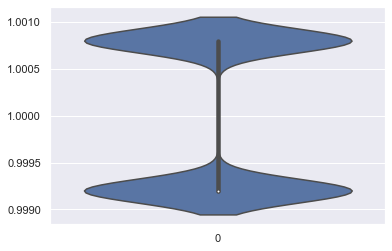

In [12]:
sns.violinplot(data=rw_unbias_data.instance_weights)
plt.show()

### Dataset metrics

In [13]:
metrics = compute_dataset_fairness_metrics(rw_unbias_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


### Classification metrics

In [14]:
rw_un_train, rw_un_test, rw_un_valid = split_data(rw_unbias_data)
x_train, y_train, x_test, y_test = x_y_split(rw_un_train, rw_un_test)
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe = pipe.fit(x_train, y_train, logisticregression__sample_weight=rw_un_train.instance_weights.ravel())
score = cross_val_score(pipe, x_test, y_test, fit_params={"logisticregression__sample_weight": rw_un_test.instance_weights.ravel()})
print("Accuracy: %f" % np.mean(score))

Accuracy: 0.845333


Balanced accuracy = 0.8494
Statistical parity difference = 0.0178
Disparate impact = 1.0375
Average odds difference = 0.0080
Equal opportunity difference = -0.0020
Theil index = 0.1121


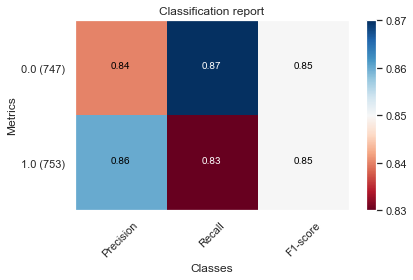

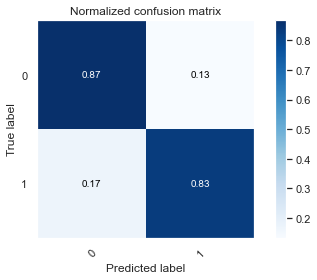

In [15]:
#rw_un_valid.features = np.delete(rw_un_valid.features, rw_un_valid.feature_names.index('s'), axis=1)
rw_un_metrics = compute_classification_metrics(pipe, rw_un_valid)
plt.show()

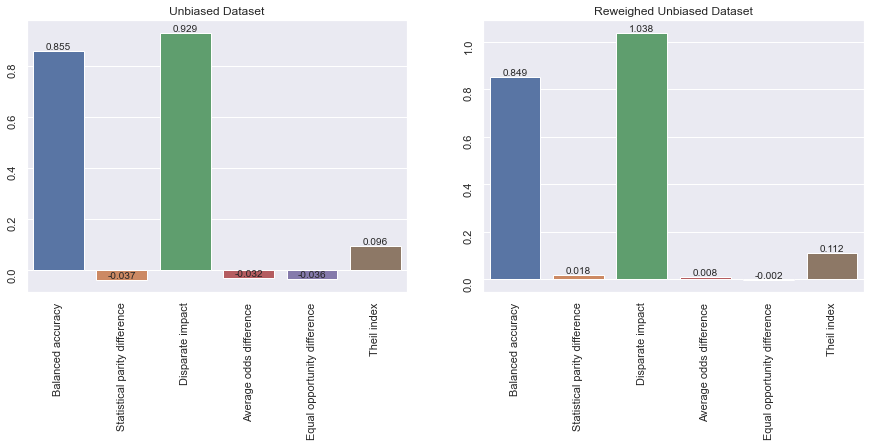

In [16]:
plot_metrics_comparison(class_metrics, rw_un_metrics, "Unbiased Dataset", "Reweighed Unbiased Dataset")
plt.show()

## Disparate Impact Remover

Here we apply the _Disparate Impact Remover_ algorithm to the unbiased dataset and see how this method impacts on the metrics defined above:

In [17]:
dir_unb_data = bin_data.copy()
scaler = MinMaxScaler(copy=False)
dir_unb_data.features = scaler.fit_transform(dir_unb_data.features)

In [18]:
di = DisparateImpactRemover(sensitive_attribute='s')
dir_unb_data = di.fit_transform(dir_unb_data)

### Dataset metrics

In [19]:
metrics = compute_dataset_fairness_metrics(dir_unb_data, unprivileged_group, privileged_group)

Disparate Impact = 0.9984
Statistical Parity = -0.0008


### Classification metrics

In [91]:
train_dir_un, test_dir_un, valid_dir_un = split_data(dir_unb_data)
x_train, y_train, x_test, y_test = x_y_split_dir(train_dir_un, test_dir_un)
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe = pipe.fit(x_train, y_train, logisticregression__sample_weight=train_dir_un.instance_weights.ravel())
score = cross_val_score(pipe, x_test, y_test, fit_params={"logisticregression__sample_weight": test_dir_un.instance_weights.ravel()})
print("Accuracy: %f" % np.mean(score))

Accuracy: 0.847333


Balanced accuracy = 0.8447
Statistical parity difference = 0.0297
Disparate impact = 1.0607
Average odds difference = 0.0358
Equal opportunity difference = 0.0207
Theil index = 0.1102


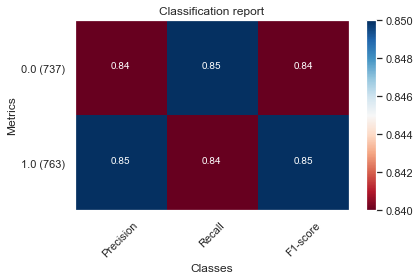

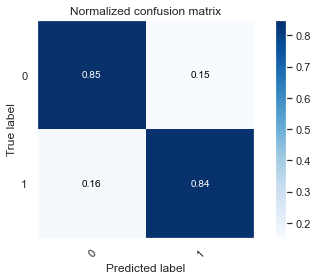

In [92]:
valid_dir_un.features = np.delete(valid_dir_un.features, valid_dir_un.feature_names.index('s'), axis=1)
dir_fair_metrics = compute_classification_metrics(pipe, valid_dir_un)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


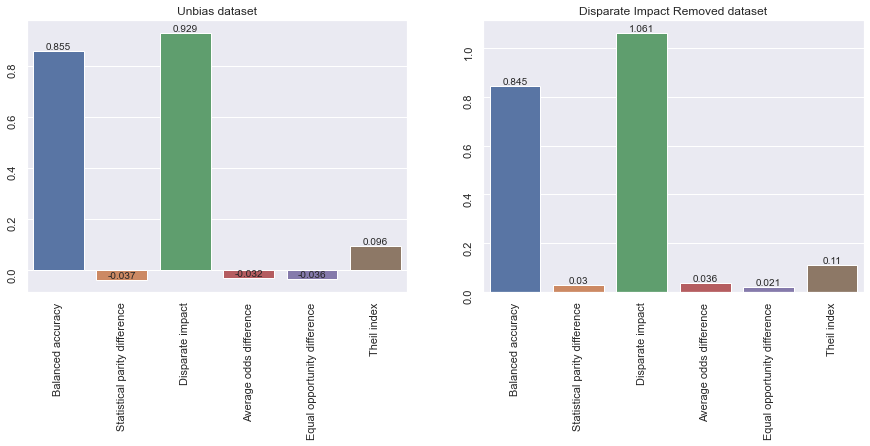

In [93]:
plot_metrics_comparison(class_metrics, dir_fair_metrics, "Unbias dataset", "Disparate Impact Removed dataset")
plt.show()

## Reweighing vs Disparate Impact Remover

In the following we compare the performances of _Reweighing_ and _Disparate Impact Remover_ on the unbias dataset. 

In [94]:
un_merged_metrics = merge_datasets({
    'Unbias Data': class_metrics,
    'Reweighed': rw_un_metrics,
    'Disparate Impact Removed': dir_fair_metrics
})

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


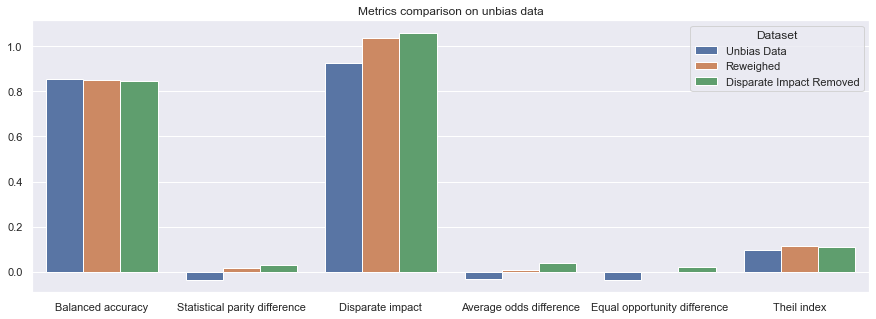

In [95]:
plot_syntesis(un_merged_metrics, 'Metrics comparison on unbias data')
plt.show()

# Unbalanced Bias dataset

Let's change the previous dataset adding a bias on the sensitive attribute `s` with value 0 and keeping the instances with `s=1` invariate:

In [96]:
bias_data = data.copy()
bias_data.loc[(bias_data['s'] == 0) & (bias_data.index < int(n_samples/2)) , 10] = 0.0

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


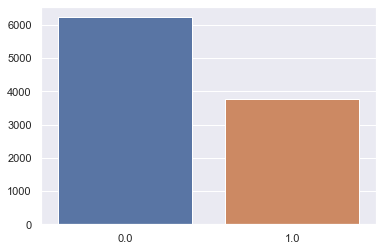

In [97]:
sns.barplot(x=bias_data[10].value_counts().index, y=bias_data[10].value_counts().values)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


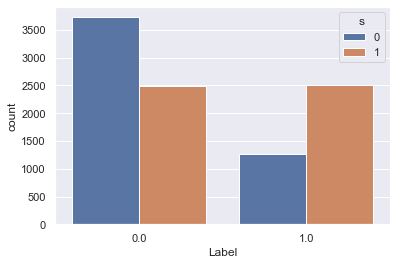

In [98]:
ax = sns.barplot(
    x=10, y='count', 
    hue='s', 
    data=bias_data.groupby('s')[10].value_counts().rename('count').reset_index(),
)
ax.set(xlabel= 'Label')
plt.show()

## Dataset fairness metrics

Let's compute the dataset fairness metrics on this new dataset:

In [99]:
bias_data_bin = BinaryLabelDataset(df = bias_data, label_names=[10], protected_attribute_names=['s'])
bias_metrics = compute_dataset_fairness_metrics(bias_data_bin, unprivileged_group, privileged_group)

Disparate Impact = 0.5080
Statistical Parity = -0.2462


## Classification bias metrics

In [100]:
bias_train, bias_test, bias_valid = split_data(bias_data_bin)

In [101]:
x_train, y_train, x_test, y_test = x_y_split(bias_train, bias_test)
bias_pipe = make_pipeline(StandardScaler(), LogisticRegression())
bias_pipe_fit = bias_pipe.fit(
    x_train, y_train, logisticregression__sample_weight=bias_train.instance_weights.ravel())
bias_accuracy = cross_val_score(bias_pipe_fit, x_test, y_test)
print("Accuracy: %f" % np.mean(bias_accuracy))

Accuracy: 0.804667


Balanced accuracy = 0.7818
Statistical parity difference = -0.2731
Disparate impact = 0.4398
Average odds difference = -0.2254
Equal opportunity difference = -0.4586
Theil index = 0.1462


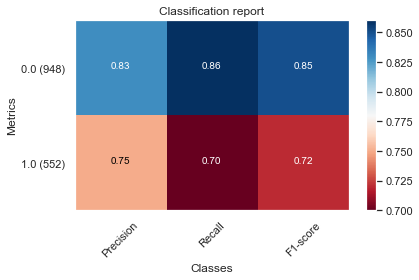

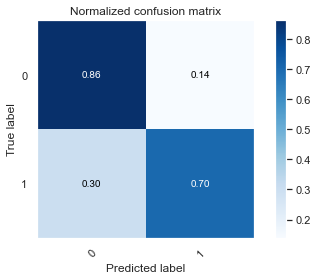

In [102]:
bias_class_metrics = compute_classification_metrics(bias_pipe_fit, bias_valid)

##  Reweighing

In [103]:
rw_data = bias_data_bin.copy(deepcopy=True)
rw = Reweighing(unprivileged_group, privileged_group)
rw_data = rw.fit_transform(rw_data)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


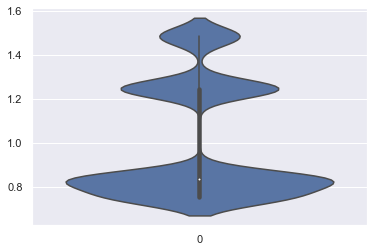

In [104]:
sns.violinplot(data=rw_data.instance_weights)
plt.show()

### Dataset metrics

In [105]:
rw_metrics = compute_dataset_fairness_metrics(rw_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


### Classification metrics

In [106]:
rw_train, rw_test, rw_valid = split_data(rw_data)
x_train, y_train, x_test, y_test = x_y_split(rw_train, rw_test)

In [107]:
rw_pipeline = make_pipeline(StandardScaler(), LogisticRegression())
rw_pipeline.fit(x_train, y_train, logisticregression__sample_weight=rw_train.instance_weights.ravel())
score = cross_val_score(
    rw_pipeline, x_test, y_test, 
    fit_params={"logisticregression__sample_weight": rw_test.instance_weights.ravel()}
)
print("Accuracy: %f" % np.mean(score))

Accuracy: 0.799333


Balanced accuracy = 0.7828
Statistical parity difference = 0.0283
Disparate impact = 1.0838
Average odds difference = -0.0093
Equal opportunity difference = -0.1690
Theil index = 0.1314


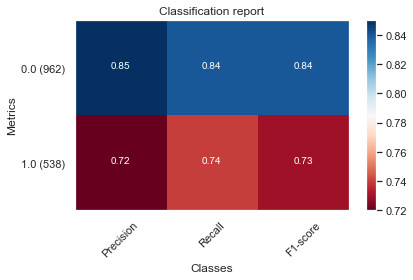

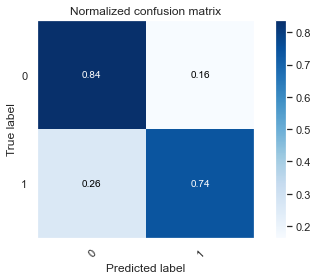

In [108]:
#rw_valid.features = np.delete(rw_valid.features, rw_valid.feature_names.index('s'), axis=1)
rw_class_metrics = compute_classification_metrics(rw_pipeline, rw_valid)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


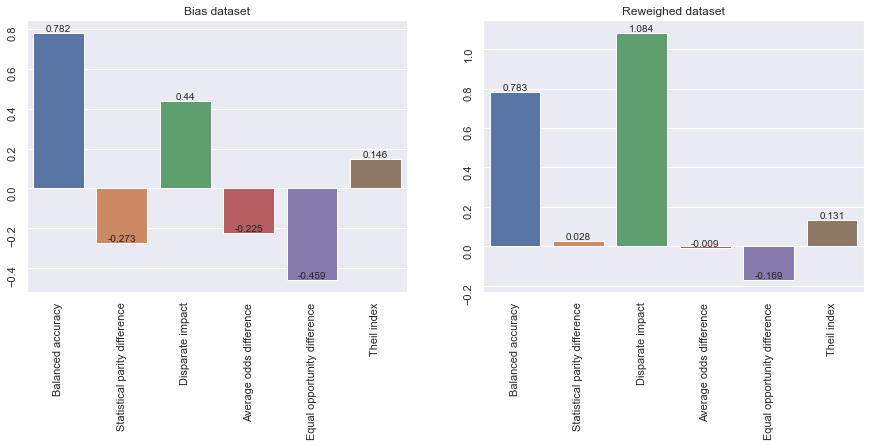

In [109]:
plot_metrics_comparison(bias_class_metrics, rw_class_metrics, "Bias dataset", "Reweighed dataset")
plt.show()

## Disparate Impact Remover

In [110]:
dir_data = bias_data_bin.copy()
scaler = MinMaxScaler(copy=False)
dir_data.features = scaler.fit_transform(dir_data.features)

In [111]:
dr = DisparateImpactRemover(sensitive_attribute='s')
dir_data = dr.fit_transform(dir_data)

### Dataset metrics

In [112]:
dir_metrics = compute_dataset_fairness_metrics(dir_data, unprivileged_group, privileged_group)

Disparate Impact = 0.5080
Statistical Parity = -0.2462


### Classification metrics

In [113]:
dir_train, dir_test, dir_valid = split_data(dir_data)

In [114]:
x_train = np.delete(dir_train.features, dir_train.feature_names.index('s'), axis=1)
y_train = dir_train.labels.ravel()
x_test = np.delete(dir_test.features, dir_test.feature_names.index('s'), axis=1)
y_test = dir_test.labels.ravel()

In [115]:
dr_pipe = make_pipeline(StandardScaler(), LogisticRegression())
dr_pipe.fit(x_train, y_train)
score = cross_val_score(dr_pipe, x_test, y_test)
print("Accuracy: %f" % np.mean(score))

Accuracy: 0.746000


Balanced accuracy = 0.7544
Statistical parity difference = -0.0097
Disparate impact = 0.9750
Average odds difference = 0.0915
Equal opportunity difference = -0.0255
Theil index = 0.1645


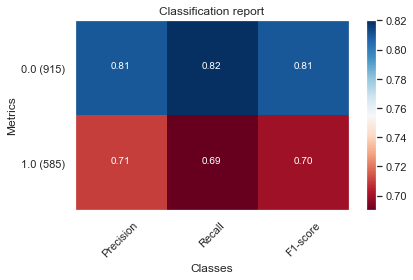

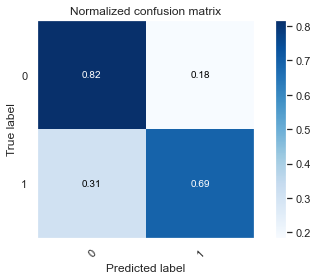

In [116]:
dir_valid_final = dir_valid.copy()
dir_valid_final.features = np.delete(dir_valid.features, dir_valid.feature_names.index('s'), axis=1)
dir_class_metrics = compute_classification_metrics(dr_pipe, dir_valid_final)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


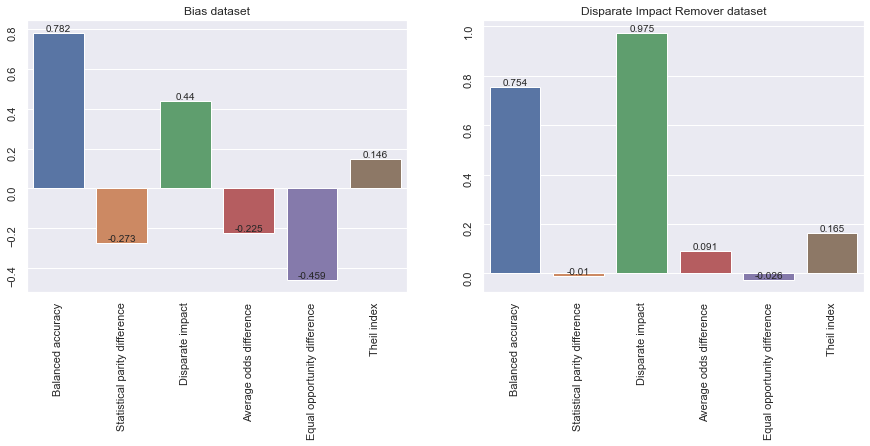

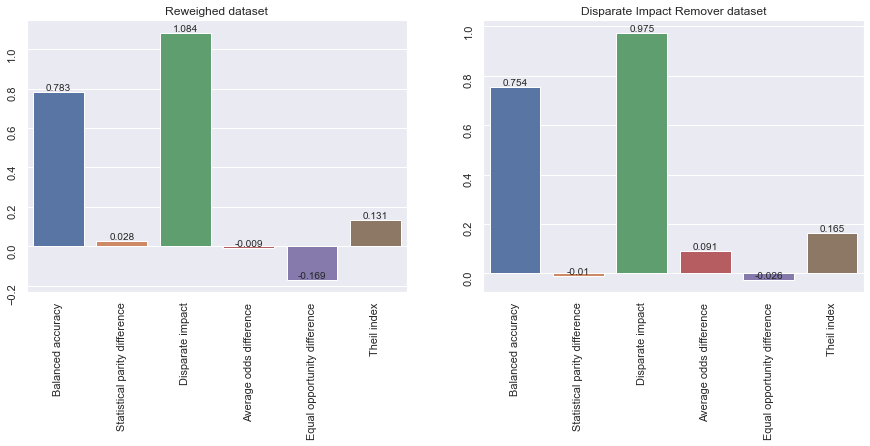

In [117]:
plot_metrics_comparison(bias_class_metrics, dir_class_metrics, "Bias dataset", "Disparate Impact Remover dataset")
plot_metrics_comparison(rw_class_metrics, dir_class_metrics, "Reweighed dataset", "Disparate Impact Remover dataset")
plt.show()

## Reweighing vs Disparate Impact Remover

In [118]:
unbal_merged_metrics = merge_datasets({
    'Bias unbalanced data':  bias_class_metrics,
    'Reweighed': rw_class_metrics,
    'Disparate Impact Removed': dir_class_metrics
})

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


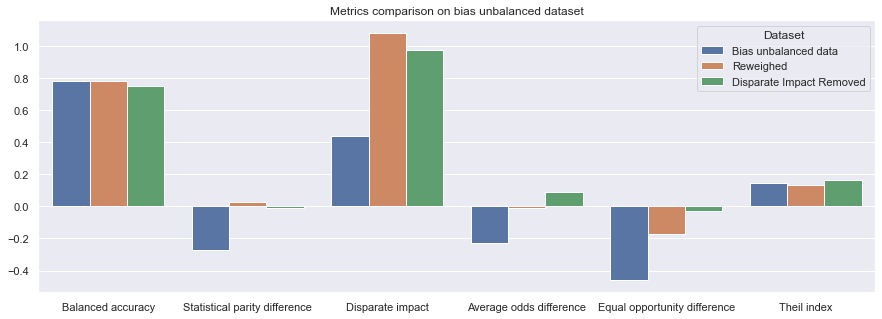

In [119]:
plot_syntesis(unbal_merged_metrics, 'Metrics comparison on bias unbalanced dataset')
plt.show()

# Bias balanced dataset

Let's balance the previous dataset changing the labels of half of the samples with `s=1` to `1.0`

In [120]:
bias_bal_data = bias_data.copy()
bias_bal_data.loc[(bias_data['s'] == 1) & (bias_data.index < int(n_samples/2)) & (bias_data[10]==0.0) , 10] = 1.0

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


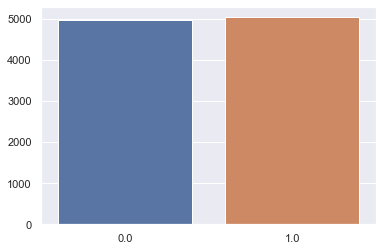

In [121]:
sns.barplot(x=bias_bal_data[10].value_counts().index, y=bias_bal_data[10].value_counts().values)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


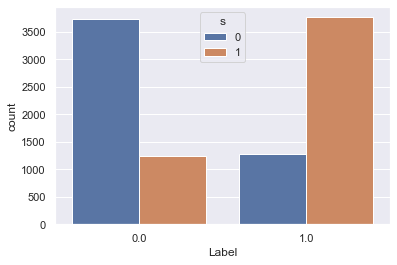

In [122]:
ax = sns.barplot(
    x=10, y='count', 
    hue='s', 
    data=bias_bal_data.groupby('s')[10].value_counts().rename('count').reset_index(),
)
ax.set(xlabel= 'Label')
plt.show()

In [123]:
bias_bal_bin = BinaryLabelDataset(df=bias_bal_data, label_names=[10], protected_attribute_names=['s'])

## Dataset metrics

In [124]:
bal_metrics = compute_dataset_fairness_metrics(bias_bal_bin, unprivileged_group, privileged_group)

Disparate Impact = 0.3378
Statistical Parity = -0.4984


## Classification metrics

In [125]:
train, test, valid = split_data(bias_bal_bin)

In [126]:
x_train, y_train, x_test, y_test = x_y_split(train, test)

In [127]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(x_train, y_train)
score = cross_val_score(pipe, x_test, y_test)
print("Accuracy: %f" % np.mean(score))

Accuracy: 0.737333


Balanced accuracy = 0.7433
Statistical parity difference = -0.7680
Disparate impact = 0.1338
Average odds difference = -0.7053
Equal opportunity difference = -0.7105
Theil index = 0.1756


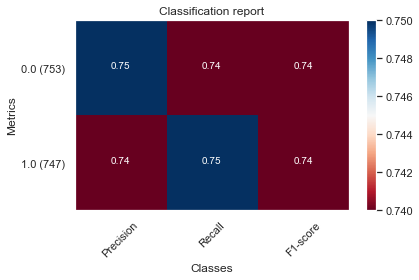

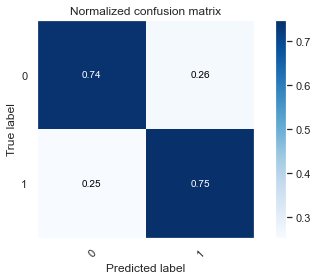

In [128]:
bias_bal_metrics = compute_classification_metrics(pipe, valid)

## Reweighing

In [129]:
rw_bal = bias_bal_bin.copy()
rw = Reweighing(unprivileged_group, privileged_group)
rw_bal = rw.fit_transform(rw_bal)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


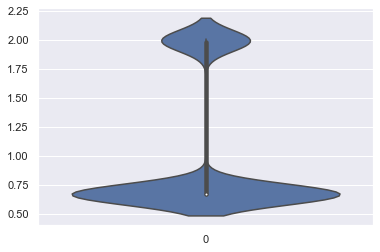

In [130]:
sns.violinplot(data=rw_bal.instance_weights)
plt.show()

### Dataset metrics

In [131]:
rw_metrics = compute_dataset_fairness_metrics(rw_bal, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


### Classification metrics

In [132]:
rw_train, rw_test, rw_valid = split_data(rw_bal)

In [133]:
x_train, y_train, x_test, y_test = x_y_split(rw_train, rw_test)

In [134]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(x_train, y_train, logisticregression__sample_weight=rw_train.instance_weights.ravel())
score = cross_val_score(pipe, x_test, y_test, 
                        fit_params={"logisticregression__sample_weight": rw_test.instance_weights.ravel()})
print("Accuracy: %f" % np.mean(score))

Accuracy: 0.701333


Balanced accuracy = 0.7309
Statistical parity difference = 0.0961
Disparate impact = 1.2168
Average odds difference = 0.1030
Equal opportunity difference = 0.1036
Theil index = 0.2111


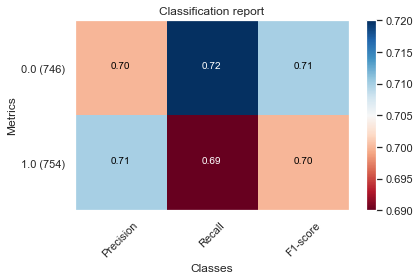

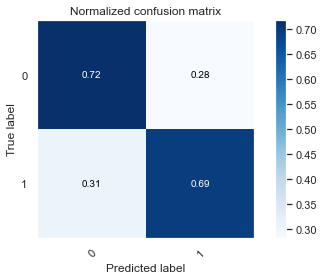

In [135]:
rw_metrics = compute_classification_metrics(pipe, rw_valid)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


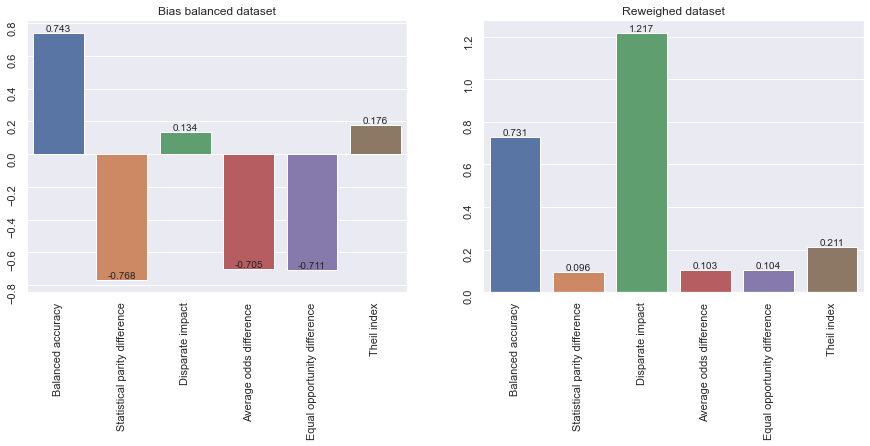

In [136]:
plot_metrics_comparison(bias_bal_metrics, rw_metrics, 'Bias balanced dataset', 'Reweighed dataset')
plt.show()

## Disparate Impact Remover

In [138]:
dir_bal = bias_bal_bin.copy()
scaler = MinMaxScaler()
dir_bal.features = scaler.fit_transform(dir_bal.features)
dr = DisparateImpactRemover(sensitive_attribute='s')
dir_bal = dr.fit_transform(dir_bal)

### Dataset metrics

In [139]:
dir_metrics = compute_dataset_fairness_metrics(dir_bal, unprivileged_group, privileged_group)

Disparate Impact = 0.3378
Statistical Parity = -0.4984


### Classification metrics

In [140]:
train, test, valid = split_data(dir_bal)

In [141]:
x_train, y_train, x_test, y_test = x_y_split_dir(train, test)

In [142]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(x_train, y_train)
score = cross_val_score(pipe, x_test, y_test)
print("Accuracy: %f" % np.mean(score))

Accuracy: 0.665333


Balanced accuracy = 0.6737
Statistical parity difference = 0.0493
Disparate impact = 1.1055
Average odds difference = 0.2539
Equal opportunity difference = 0.2533
Theil index = 0.2523


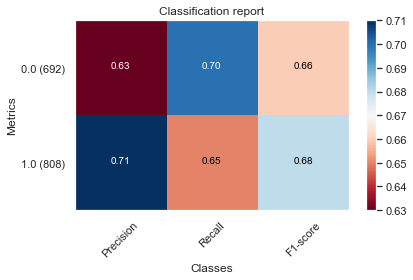

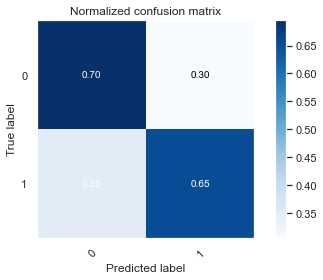

In [143]:
valid_copy = valid.copy()
valid_copy.features = np.delete(valid.features, valid.feature_names.index('s'), axis=1)
dir_score = compute_classification_metrics(pipe, valid_copy)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


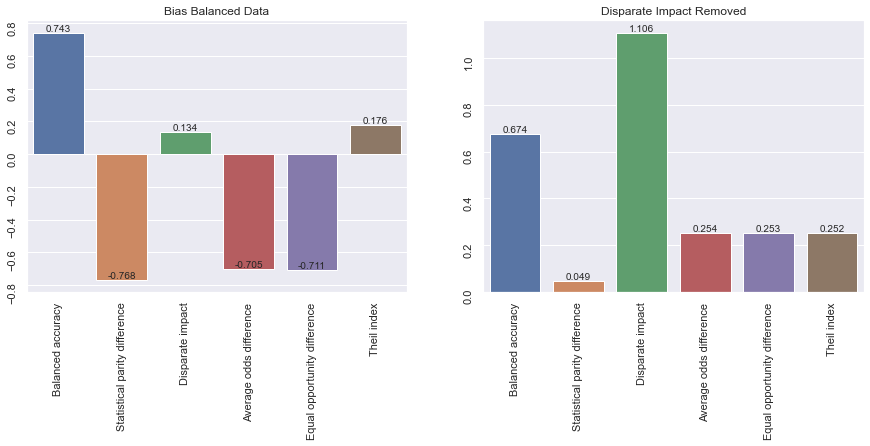

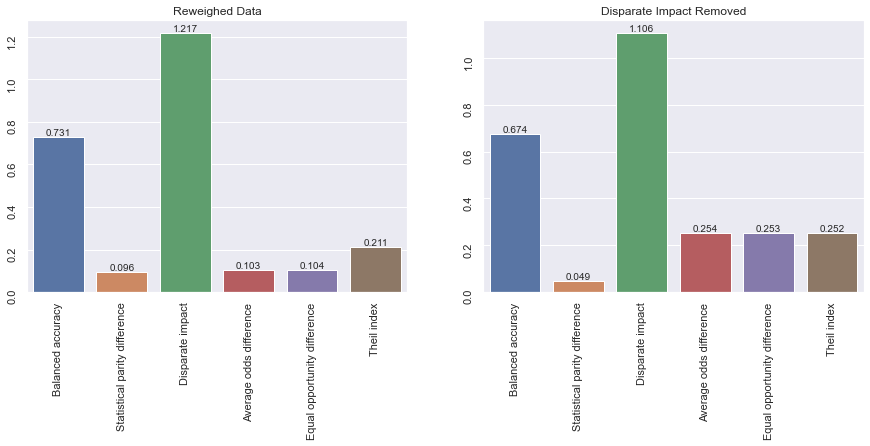

In [144]:
plot_metrics_comparison(bias_bal_metrics, dir_score, 'Bias Balanced Data', 'Disparate Impact Removed')
plot_metrics_comparison(rw_metrics, dir_score, 'Reweighed Data', 'Disparate Impact Removed')
plt.show()

## Reweighing vs Disparate Impact Remover

In [145]:
bal_merged_metrics = merge_datasets({
    'Bias Balanced Data': bias_bal_metrics,
    'Reweighed': rw_metrics,
    'Disparate Impact Removed': dir_score
})

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


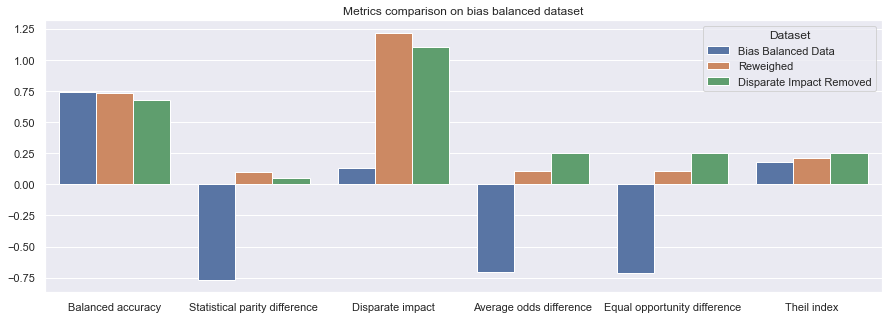

In [146]:
plot_syntesis(bal_merged_metrics, 'Metrics comparison on bias balanced dataset')
plt.show()

# Comparison of the three datasets

Here we compare the metrics for the three versions of the dataset and the methods applied:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


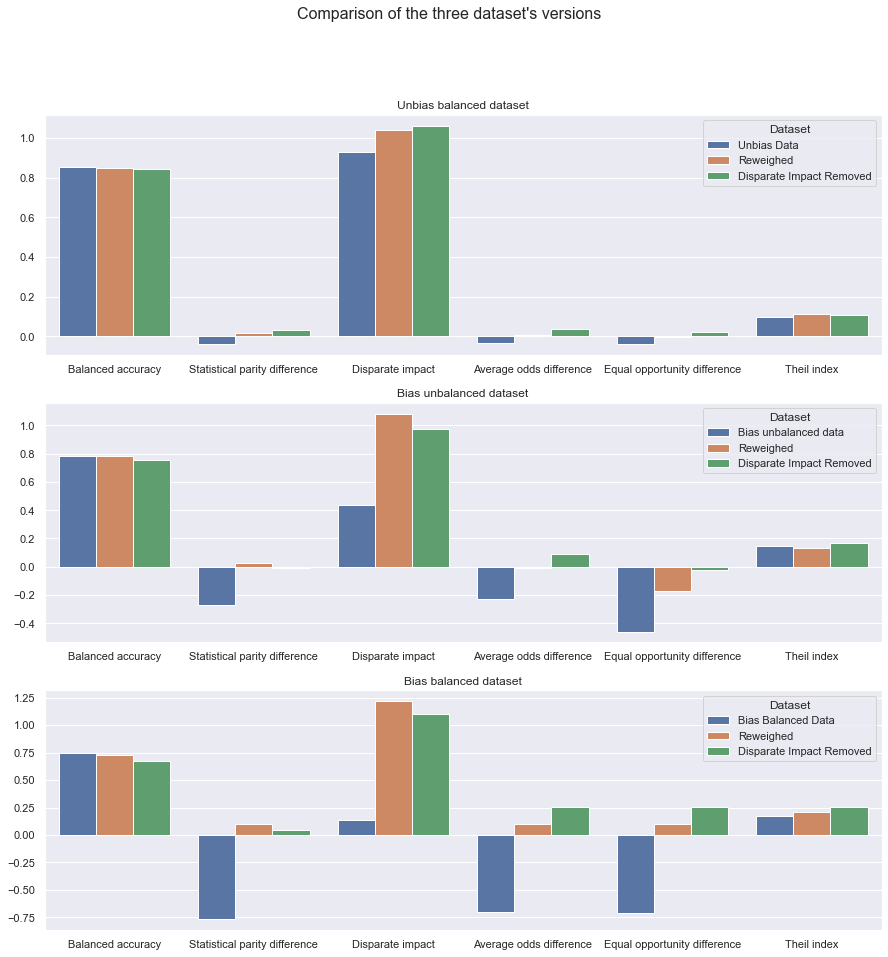

In [147]:
fig, axes = plt.subplots(3,1,figsize=(15,15))
sns.barplot(data=un_merged_metrics, x='metrics', y='values', hue='Dataset',ax=axes[0],)
sns.barplot(data=unbal_merged_metrics, x='metrics', y='values', hue='Dataset',ax=axes[1])
sns.barplot(data=bal_merged_metrics, x='metrics', y='values', hue='Dataset',ax=axes[2])
for ax in axes:
    ax.set(xlabel='', ylabel='')
axes[0].set_title('Unbias balanced dataset')
axes[1].set_title('Bias unbalanced dataset')
axes[2].set_title('Bias balanced dataset')
fig.suptitle("Comparison of the three dataset's versions", fontsize=16)
plt.show()

# Combine Reweighing and DIR

As can be seen from the charts above both RW and DIR performs well in mitigating the unfairness of the classifier. However both have some lacks:

1. Reweighing requires that a classifier takes account of instance weights, but not all the classifier models do so
2. Disparate Impact Remover has no effect on the dataset fairness metrics but only on the classifier metrics

To solve these problems we will now try to combine these two algorithms by applying the instance weights to the DIR modified dataset and see the results.

## Test with unbias data

In [148]:
un_rw_dir = dir_unb_data.copy(deepcopy=True)
rw = Reweighing(unprivileged_group, privileged_group)
un_rw_dir = rw.fit_transform(un_rw_dir)

In [149]:
score = compute_dataset_fairness_metrics(un_rw_dir, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


In [150]:
train, test, val = split_data(un_rw_dir)

In [151]:
x_train, y_train, x_test, y_test = x_y_split_dir(train, test)

In [152]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(x_train, y_train, logisticregression__sample_weight=train.instance_weights.ravel())
score = cross_val_score(pipe, x_test, y_test, 
                        fit_params={"logisticregression__sample_weight": test.instance_weights.ravel()})
print("Accuracy: %f" % np.mean(score))

Accuracy: 0.837333


Balanced accuracy = 0.8586
Statistical parity difference = 0.0422
Disparate impact = 1.0929
Average odds difference = 0.0111
Equal opportunity difference = 0.0338
Theil index = 0.1076


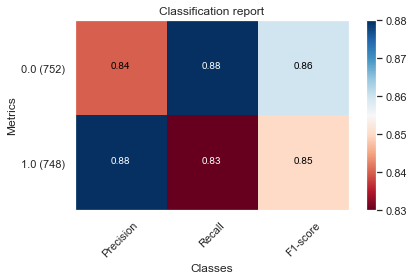

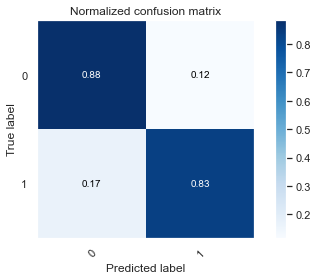

In [153]:
val_c = val.copy()
val_c.features = np.delete(val_c.features, val_c.feature_names.index('s'), axis=1)
unb_rw_dir_score = compute_classification_metrics(pipe, val_c)

In [154]:
un_rw_dir_merg =  merge_datasets({
    'Unbias Data': class_metrics,
    'Reweighed': rw_un_metrics,
    'Disparate Impact Removed': dir_fair_metrics,
    'RW + DIR': unb_rw_dir_score
})

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


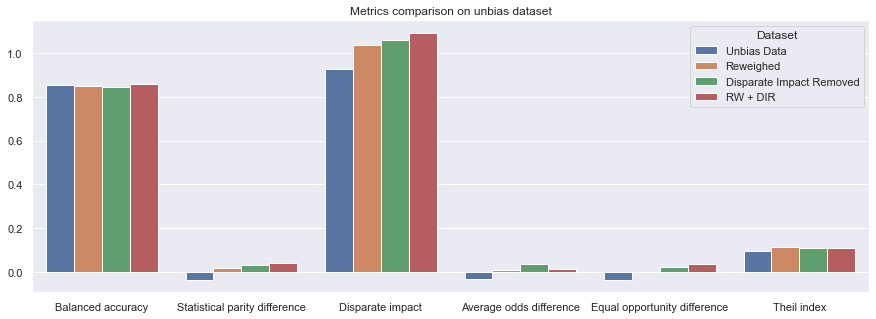

In [155]:
plot_syntesis(un_rw_dir_merg, 'Metrics comparison on unbias dataset')
plt.show()

## Test with unbalance bias data

In [156]:
unbal_dir_rw_data = dir_data.copy()
rw = Reweighing(unprivileged_group, privileged_group)
unbal_dir_rw_data = rw.fit_transform(unbal_dir_rw_data)

In [157]:
score = compute_dataset_fairness_metrics(unbal_dir_rw_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


In [158]:
train, test, val = split_data(unbal_dir_rw_data)

In [159]:
x_train, y_train, x_test, y_test = x_y_split_dir(train ,test)

In [160]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(x_train, y_train, logisticregression__sample_weight=train.instance_weights.ravel())
score = cross_val_score(pipe, x_test, y_test, 
                        fit_params={"logisticregression__sample_weight": test.instance_weights.ravel()})
print("Accuracy: %f" % np.mean(score))

Accuracy: 0.758667


Balanced accuracy = 0.7960
Statistical parity difference = 0.1398
Disparate impact = 1.4493
Average odds difference = 0.1060
Equal opportunity difference = -0.0114
Theil index = 0.1329


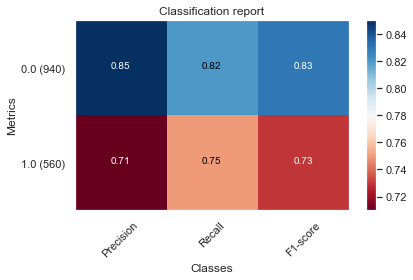

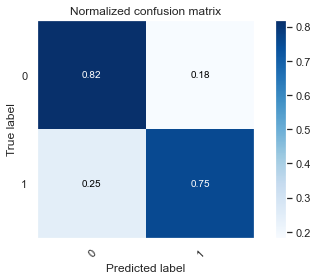

In [162]:
val_c = val.copy()
val_c.features = np.delete(val_c.features, val_c.feature_names.index('s'), axis=1)
rw_dir_score = compute_classification_metrics(pipe, val_c)

In [163]:
unbal_rw_dir_score = merge_datasets({
    'Bias unbalanced data':  bias_class_metrics,
    'Reweighed': rw_class_metrics,
    'Disparate Impact Removed': dir_class_metrics,
    'RW + DIR': rw_dir_score
})

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


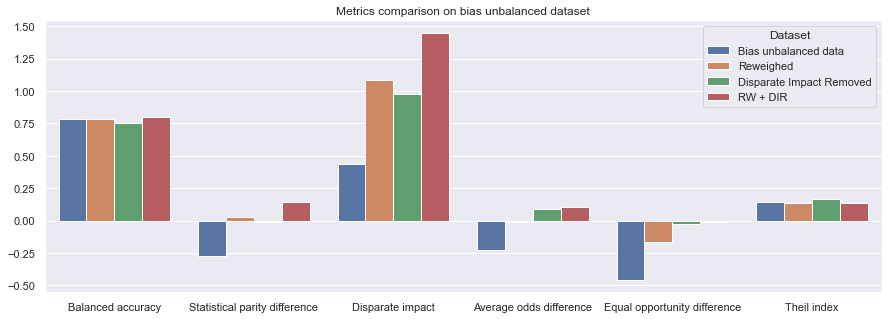

In [164]:
plot_syntesis(unbal_rw_dir_score, 'Metrics comparison on bias unbalanced dataset')
plt.show()

## Test with balanced bias data

In [166]:
dir_rw_data = dir_bal.copy()
rw = Reweighing(unprivileged_group, privileged_group)
dir_rw_data = rw.fit_transform(dir_rw_data)

In [167]:
score = compute_dataset_fairness_metrics(dir_rw_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


In [168]:
train, test, val = split_data(dir_rw_data)

In [169]:
x_train, y_train, x_test, y_test = x_y_split_dir(train, test)

In [170]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(x_train, y_train, logisticregression__sample_weight=train.instance_weights.ravel())
score = cross_val_score(pipe, x_test, y_test, 
                        fit_params={"logisticregression__sample_weight": test.instance_weights.ravel()})
print("Accuracy: %f" % np.mean(score))

Accuracy: 0.688667


Balanced accuracy = 0.7430
Statistical parity difference = 0.2598
Disparate impact = 1.7470
Average odds difference = 0.2632
Equal opportunity difference = 0.2392
Theil index = 0.2429


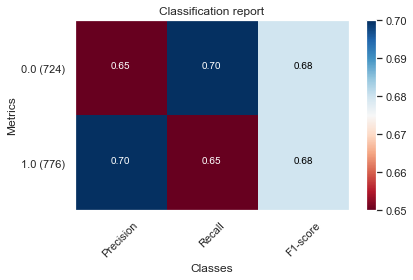

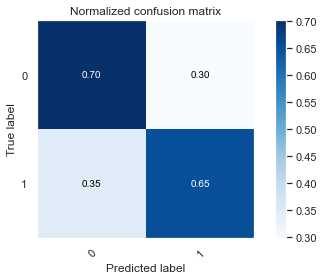

In [171]:
val_c = val.copy()
val_c.features = np.delete(val_c.features, val_c.feature_names.index('s'), axis=1)
rw_dir_score = compute_classification_metrics(pipe, val_c)

In [172]:
rw_dir_merged_metrics = merge_datasets({
    'Bias Balanced Data': bias_bal_metrics,
    'Reweighed': rw_metrics,
    'Disparate Impact Removed': dir_score,
    'RW + DIR': rw_dir_score
})

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


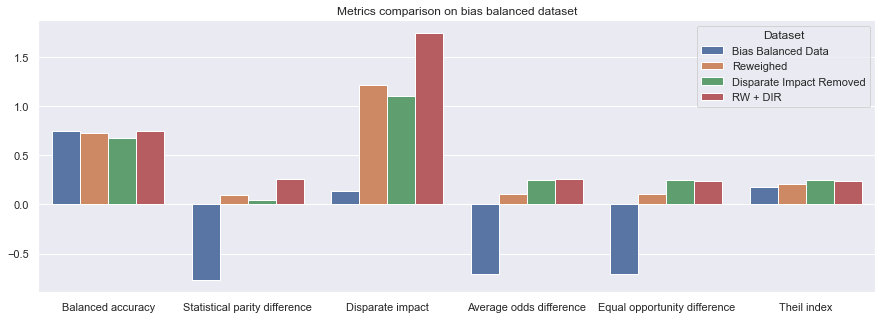

In [173]:
plot_syntesis(rw_dir_merged_metrics, 'Metrics comparison on bias balanced dataset')
plt.show()